<a href="https://colab.research.google.com/github/KarolinaA09/Karolina-Acosta/blob/main/Ejercicio_S11_Clasificaci%C3%B3n_de_la_calidad_de_limones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio semana 11 - Clasificación de la calidad de limones**




In [1]:
!pip install keras-tuner
!pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.4 MB/s eta 0:00:00


In [11]:
import os
import shutil
import tensorflow as tf
from skopt import gp_minimize
import keras_tuner
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
original_dir = '/content/drive/MyDrive/DECIMO SEMESTRE/VISION POR COMPUTADOR /Lemon_quality/Lemon_quality'

base_dir = '/content/drive/MyDrive/DECIMO SEMESTRE/VISION POR COMPUTADOR /Lemon_quality_dataset'
os.makedirs(base_dir, exist_ok=True)

categories = ['good_quality', 'bad_quality']

In [4]:
for category in categories:
    os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)

for category in categories:
    category_dir = os.path.join(original_dir, category)
    file_list = os.listdir(category_dir)

    train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    for file_name in train_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'train', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in valid_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'validation', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in test_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'test', category, file_name)
        shutil.copyfile(src, dst)

for split in ['train', 'validation', 'test']:
    for category in categories:
        category_dir = os.path.join(base_dir, split, category)
        print(f"{split} {category} images: {len(os.listdir(category_dir))}")

train good_quality images: 900
train bad_quality images: 910
validation good_quality images: 112
validation bad_quality images: 185
test good_quality images: 113
test bad_quality images: 179


In [5]:
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1809 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [6]:
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv2_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv3_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner',
    project_name='lemon_quality')

tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=5,
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 5 Complete [00h 00m 52s]
val_accuracy: 0.9663299918174744

Best val_accuracy So Far: 0.9831649661064148
Total elapsed time: 00h 05m 18s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 112)     3136      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 112)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        64576     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64

In [7]:
# Definición del modelo
model = Sequential([
    Conv2D(112, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(80, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/10
56/56 [==============================] - 11s 171ms/step - loss: 0.4598 - accuracy: 0.7698 - val_loss: 0.1750 - val_accuracy: 0.9444
Epoch 2/10
56/56 [==============================] - 9s 157ms/step - loss: 0.2564 - accuracy: 0.8959 - val_loss: 0.1913 - val_accuracy: 0.9201
Epoch 3/10
56/56 [==============================] - 9s 169ms/step - loss: 0.1391 - accuracy: 0.9477 - val_loss: 0.1702 - val_accuracy: 0.9271
Epoch 4/10
56/56 [==============================] - 9s 167ms/step - loss: 0.0933 - accuracy: 0.9645 - val_loss: 0.0589 - val_accuracy: 0.9722
Epoch 5/10
56/56 [==============================] - 9s 153ms/step - loss: 0.1786 - accuracy: 0.9285 - val_loss: 0.2475 - val_accuracy: 0.9201
Epoch 6/10
56/56 [==============================] - 10s 180ms/step - loss: 0.2259 - accuracy: 0.9077 - val_loss: 0.0842 - val_accuracy: 0.9722
Epoch 7/10
56/56 [==============================] - 11s 189ms/step - loss: 0.1403 - accuracy: 0.9516 - val_loss: 0.0556 - val_accuracy: 0.9826
Epo

In [8]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')

9/9 [==============================] - 16s 2s/step - loss: 0.0435 - accuracy: 0.9792
Test accuracy: 0.9791666865348816


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

1/1 [==============================] - 0s 293ms/step


<ipython-input-20-53ec21a9aeca>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_labels[int(y[i])]}\nPred: {class_labels[int(predictions[i] > 0.5)]}")


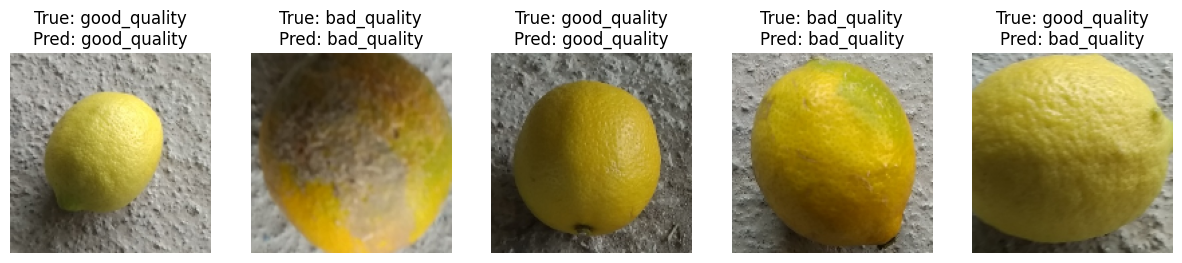

In [20]:
# Función para mostrar imágenes con predicciones
def show_predictions(model, generator, class_labels, num_images=5):
    x, y = next(generator)
    predictions = model.predict(x)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x[i])
        plt.title(f"True: {class_labels[int(y[i])]}\nPred: {class_labels[int(predictions[i] > 0.5)]}")
        plt.axis('off')
    plt.show()

# Etiquetas de clase
class_labels = list(train_generator.class_indices.keys())

# Mostrar predicciones en el conjunto de prueba
show_predictions(model, test_generator, class_labels,num_images=5)